# Speech Sample Analysis

This notebook goes through a simple analysis of a single speech sample

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from speechbrain.processing.voice_analysis import vocal_characteristics

In [2]:
# Load audio and generate stats
audio, sample_rate = torchaudio.load("qpn_PD00020_a1.wav")
f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio.squeeze(), sample_rate=sample_rate)

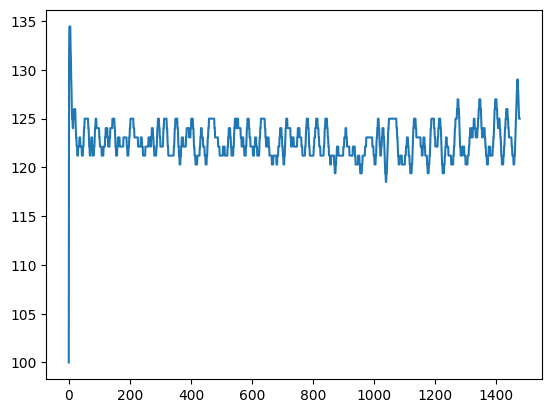

In [3]:
# What does f0 look like
plt.plot(f0)

In [4]:
print(f0.shape)

torch.Size([1477])


In [5]:
print(voiced.shape)

torch.Size([1683])


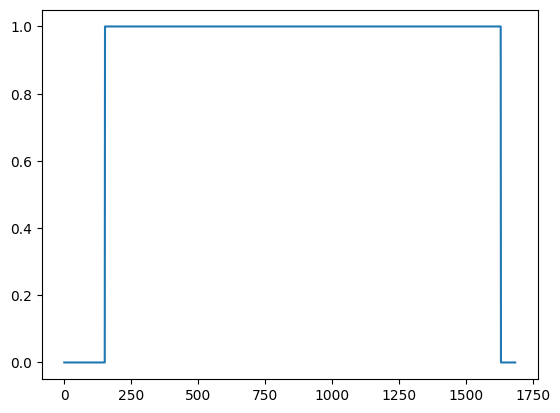

In [6]:
plt.plot(voiced)

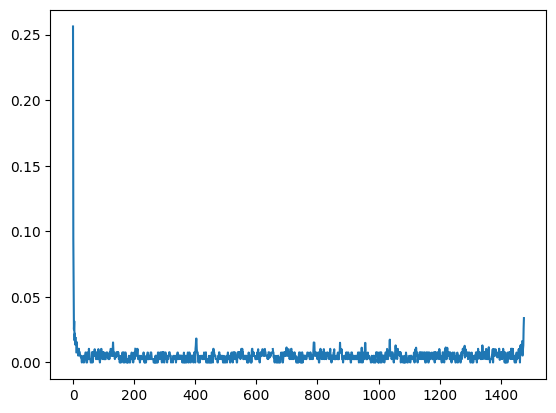

In [7]:
plt.plot(jitter)

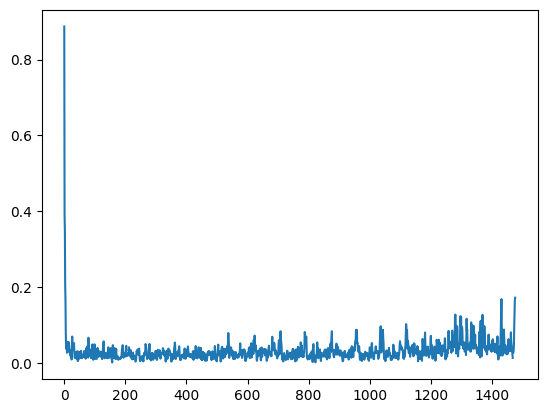

In [8]:
plt.plot(shimmer)

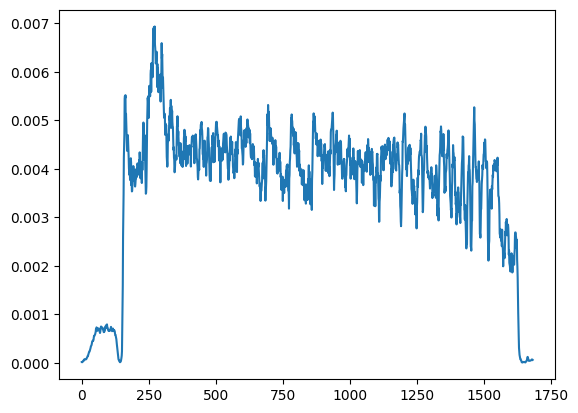

In [9]:
plt.plot(hnr)